# 1st Zermelo problem (permanent control)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4.
    \end{array}
    \right.
$$


In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirectS
  t; x1; x2 ; u; p1 ; p2
end

In [3]:
function ZERMELO(x0; solution=[], nsteps=1000, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
        x1[1:N+1]                 # x1
        x2[1:N+1]                 # x2
        -π/2 ≤ u[1:N+1] ≤ π/2     # Control
    end)
    
    Δt  =  8.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Max, x1[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]   == x0[1]                #initial condition
        con_x20, x2[1]   == x0[2]                #initial condition
        con_x2f, x2[N+1] == 4.0                  #final condition 

        end)
    
    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j] + cos(u[j]) )
    @NLexpression(sys, dx2[j = 1:N+1], sin(u[j]))    
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j]) 
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return DirectS(t, x1, x2, u, p1, p2)
        
end;

In [4]:
# Resolution
x0  = [0.0; 0.0]

sol = ZERMELO(x0);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    10003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4000

Total number of variables............................:     3003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1001
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2003
Total number of in

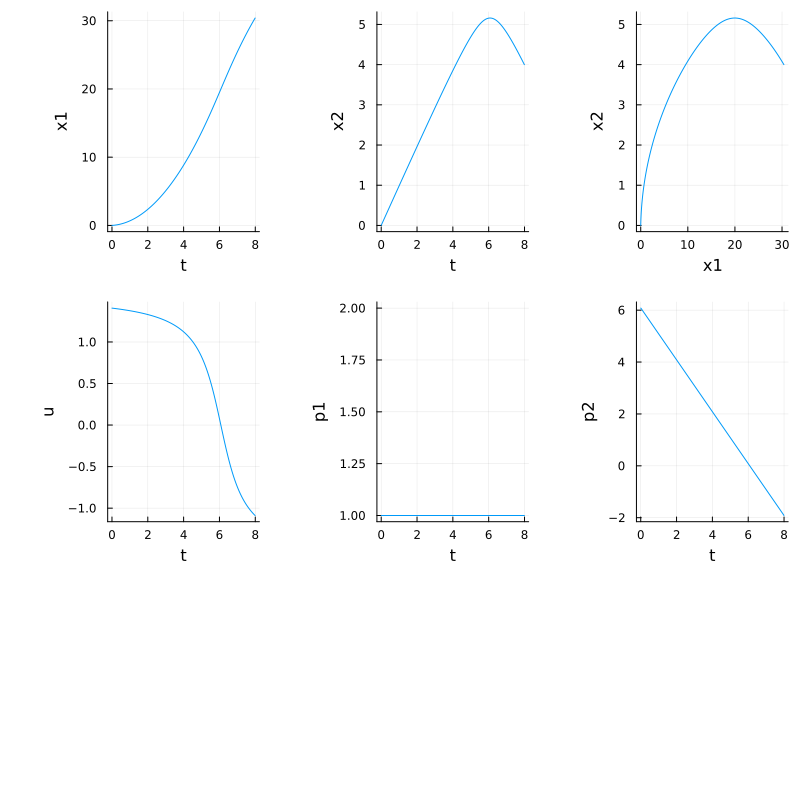

In [6]:
# Plots
t  = sol.t
x1 = sol.x1
x2 = sol.x2
u  = sol.u
p1 = sol.p1
p2 = sol.p2


x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
p1_plot   = plot(t, p1,  xlabel = "t", ylabel = "p1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
p2_plot   = plot(t, p2,  xlabel = "t", ylabel = "p2",  legend = false)

u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot,p1_plot, p2_plot, layout = (3,3), size=(800,800), left_margin=10mm)

# Indirect method

In [7]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [8]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

# Hamiltonians: permanent region
H(x, u, p)  = p' * F(x, u)     # pseudo-Hamiltonian
u1(x, p) = atan(p[2]/p[1])
Hp(x, p) = H(x, u1(x, p) , p ) # true Hamiltonian

# Flows
fp  = Flow(Hp);

In [9]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]

# Shooting function
function shoot(p0) 

    xf, pf = fp(t0, x0, p0, tf)

    s = zeros(eltype(p0), 2)
    s[1] = xf[2] - x2f # target
    s[2] = pf[1] - 1.0 # transversality condition
        
    return s

end;


In [10]:
# Solve

S(ξ) = shoot(ξ[1:2])

ξ_guess = [p1[1], p2[1]] # initial guess

println("Initial value of shooting:\n", S(ξ_guess), "\n\n")

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    p0 = indirect_sol.zero[1:2]
else
    error("Not converged")
end;

Initial value of shooting:
[-0.007087451129545563, 0.0]


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     7.087451e-03              NaN
     1     6.737216e-07     3.782282e-03
     2     1.438849e-13     3.596060e-07
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.077883358183904]
 * Zero: [1.0, 6.081665999466395]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3


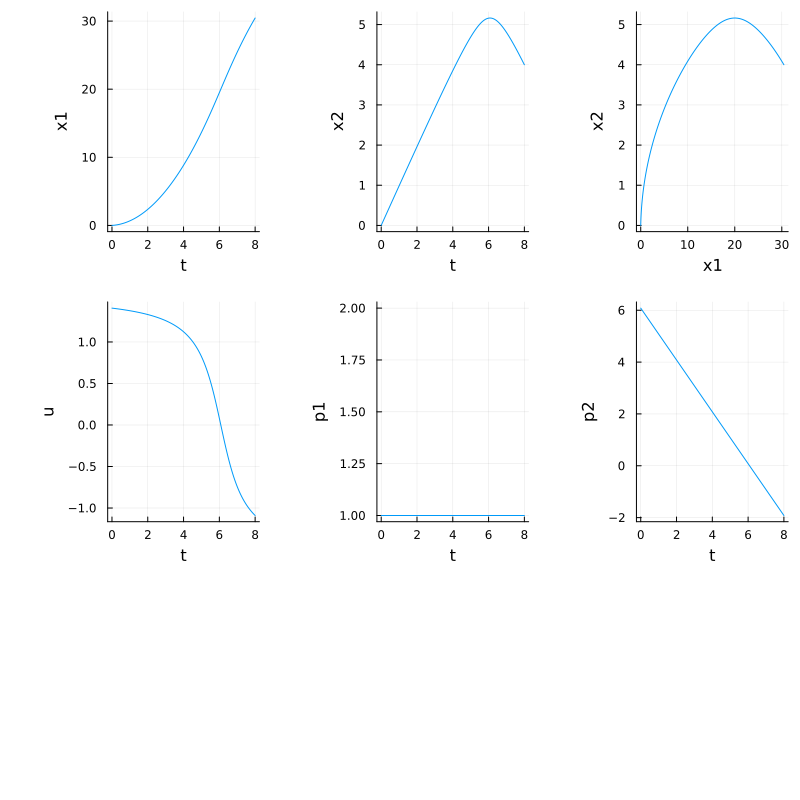

In [11]:
# plots

ode_sol = fp((t0, tf), x0, p0, saveat=0.01)


tt = ode_sol.t

x  = [ ode_sol[1:2, j] for j in 1:size(tt, 1) ]
x1 = [el[1] for el in x]
x2 = [el[2] for el in x]

p  = [ ode_sol[3:4, j] for j in 1:size(tt, 1) ]
p1 = [el[1] for el in p]
p2 = [el[2] for el in p]

u = u1.(x, p)

x1_plot   = plot(tt,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(tt,  x2, xlabel = "t", ylabel = "x2",  legend = false)
u_plot    = plot(tt,    u, xlabel = "t", ylabel = "u",  legend = false)
p1_plot   = plot(tt,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(tt,  p2, xlabel = "t", ylabel = "p2", legend = false)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot,p1_plot, p2_plot, layout = (3,3), size=(800,800), left_margin=10mm)